# FastAI Tabular Data Neural Network

Attempt to get fastai.tabular_learner() to solve this linear regression problem.

- layers=[200,100,50]  + fit_one_cycle(150) - Kaggle score is 3.25917 (terrible) and most predictions are an order of magnitude too low
- layers=[1000,200,50] + fit_one_cycle(20)  - Kaggle score is 2.43697 (terrible)
- layers=[100, 50]     + fit_one_cycle(20)  - Kaggle score is 1.04220 (terrible) 
- layers=[100, 50]     + fit_one_cycle(200) - Kaggle score is 1.04220 (terrible) 
- layers=[50]          + fit_one_cycle(200) - Kaggle score is 1.04220 (terrible) 

wd=0.1 + SalePriceLog + exclude SalePrice from X"
- layers=[100, 50]     + fit_one_cycle(20)    - Kaggle score is 0.16766 (almost as good as ARDFeatures.csv) 
- layers=[200,200,100,100,50,50,25] + fit(50) - Kaggle score is 0.13014 (+rank 1817/4926) 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.basic_data import DatasetType
from fastai.tabular.data import TabularDataBunch, TabularList
from fastai.tabular.transform import FillMissing, Categorify, Normalize
from fastai.tabular.learner import tabular_learner
from fastai.metrics import accuracy, r2_score, root_mean_squared_error, mean_squared_logarithmic_error
from fastai.data_block import FloatList
import numpy as np
import pandas as pd
import random
import pydash
import torch

# from fastai.structured import *
# np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
fastai.torch_core.defaults.device = 'cpu'

In [4]:
df = pd.read_csv('data/train.csv')
df.SalePrice    = df.SalePrice.astype(float); # Float implies a regression problem rather than categorization 
df['SalePriceLog'] = np.log( df.SalePrice )
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,12.429216


In [5]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
test_df = pd.read_csv('data/test.csv').fillna(0)
# test_df['SalePrice']    = 0.0
# test_df['SalePriceLog'] = 0.0
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,...,120,0,0,MnPrv,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,0,IR1,Lvl,AllPub,...,0,0,0,MnPrv,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,0,IR1,HLS,AllPub,...,144,0,0,0,0,0,1,2010,WD,Normal


In [7]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
procs = [FillMissing, Categorify, Normalize]
cat_names = [
    'CentralAir',
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
    "MoSold",
    "LandSlope", "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities",
    "LotConfig", "Neighborhood", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "MasVnrType", "Foundation",
    "BsmtExposure", "Heating", "Functional", "GarageFinish", "Fence", "SaleType", "SaleCondition",
    "MiscFeature", "Electrical", "GarageType", "PavedDrive",
    "Condition1", "Condition2",
    "Exterior1st", "Exterior2nd",
    "BsmtFinType1", "BsmtFinType2",
]
cont_names = [ x for x in df.columns if x not in cat_names and x not in ['SalePrice', 'SalePriceLog'] ]  # important to exclude SalePrice from X

In [9]:
valid_idx  = random.sample( range(0, len(df)), len(df)//5)

In [10]:
# max_log_y = np.log( np.max(df['SalePrice'])*1.2 )
max_y   = np.max(df['SalePriceLog']) * 1.2
min_y   = 0
y_range = torch.tensor([min_y, max_y])

In [11]:
data = TabularDataBunch.from_df(
    './data/', df, 
    dep_var='SalePriceLog', 
    valid_idx=valid_idx,
    test_df=test_df,
    procs=[FillMissing, Categorify, Normalize], 
    cat_names=cat_names,
    cont_names=cont_names,
)
# data.add_test(TabularList.from_df(
#     test_df,
#     procs=[FillMissing, Categorify, Normalize],     
#     cat_names=cat_names,
#     cont_names=cont_names,
# ))
# data

In [12]:
# NOTE: root_mean_squared_error throes AssertionError: Expected output and target to have the same number of elements but got 36608 and 64.
#       but only when SalesPrice is int for categorization and not float for regression
learn = tabular_learner(data=data, layers=[1000, 500, 250], 
   metrics=[root_mean_squared_error, mean_squared_logarithmic_error],                           
   wd=0.1,
#  use_bn=False,
#  y_range=y_range
)
# learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


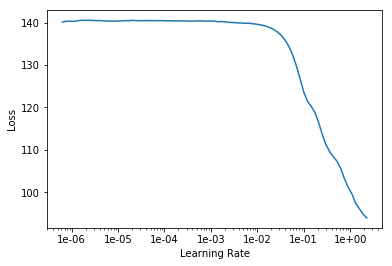

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(200, 1e-01)

epoch,train_loss,valid_loss,root_mean_squared_error,mean_squared_logarithmic_error,time
0,136.308975,131.529022,11.468577,4.584257,00:03
1,127.378799,103.267059,10.161876,2.409186,00:04
2,105.768272,44.621281,6.679734,0.525984,00:03
3,69.547913,3.277227,1.807249,0.016144,00:02
4,46.281528,0.520523,0.718843,0.003534,00:02
5,31.029770,0.213246,0.460164,0.001334,00:02
6,20.842262,0.525497,0.724745,0.003259,00:02
7,14.178285,0.056037,0.236277,0.000331,00:02
8,9.713369,0.125790,0.345821,0.000916,00:02
9,6.690768,0.041928,0.203046,0.000252,00:02


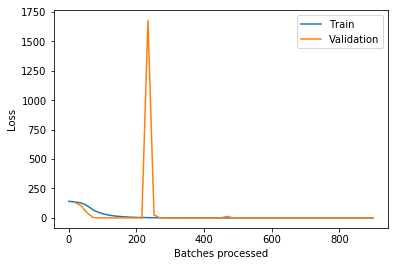

In [16]:
learn.recorder.plot_losses()

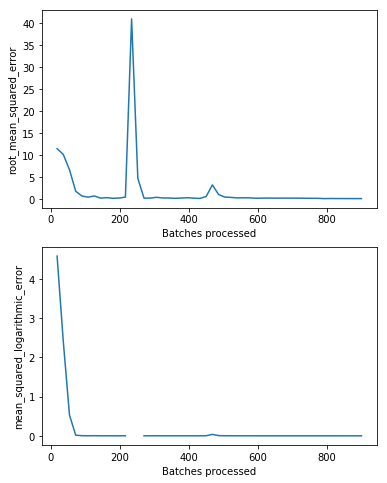

In [17]:
learn.recorder.plot_metrics()

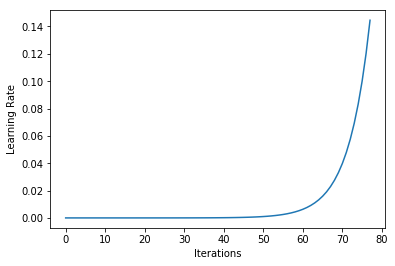

In [19]:
learn.recorder.plot_lr()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


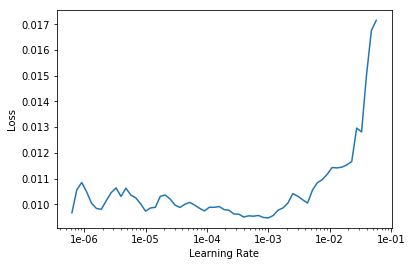

In [18]:
learn.lr_find()
learn.recorder.plot()

In [20]:
# learn.fit_one_cycle(20, 2e-04)

epoch,train_loss,valid_loss,root_mean_squared_error,mean_squared_logarithmic_error,time
0,0.012339,0.017292,0.130342,0.000106,00:04
1,0.011697,0.017428,0.130807,0.000107,00:04
2,0.010999,0.017898,0.132613,0.000110,00:03
3,0.010753,0.017984,0.132866,0.000111,00:03
4,0.010547,0.017888,0.132571,0.000110,00:03
5,0.010754,0.017617,0.131554,0.000108,00:03
6,0.010356,0.017673,0.131851,0.000108,00:03
7,0.010619,0.017833,0.132407,0.000110,00:03
8,0.010623,0.017686,0.131848,0.000109,00:03
9,0.010631,0.018122,0.133496,0.000111,00:03


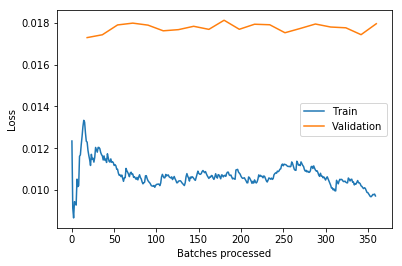

In [21]:
learn.recorder.plot_losses()

In [22]:
preds = learn.get_preds(ds_type=DatasetType.Test)[0].numpy().flatten();

submission_df = pd.DataFrame({
    'Id':        test_df['Id'], 
    'SalePrice': np.exp( preds )
})
submission_df.to_csv('data/submissions/fastai.csv', header=True, index=False)
submission_df.head()

,Id,SalePrice
0,1461,131485.343750
1,1462,159400.109375
2,1463,181773.640625
3,1464,190420.140625
4,1465,186051.281250


# Submit to Kaggle

```
kaggle competitions submit -c house-prices-advanced-regression-techniques -f data/submissions/fastai.csv -m "Fastai tabular_learner"
```